<a href="https://colab.research.google.com/github/fardinafdideh/NeuroAlignedYarrows/blob/main/NeuroAI_Project_NeuroAlignedYarrows_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMA Project - Microlearning - NeuroAlignedYarrows Team

***Evaluating Biologically Plausible Learning Rules in Feedforward Networks under different tasks***

In [1]:
# @title Import dependencies

# Standard library imports
import logging
from datetime import datetime
import pdb  # we encourage you to use the debugger, rather than print statements!
import time
import itertools
import random

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from IPython.display import display, HTML

# Our imports
import seaborn as sns
import pandas as pd

In [2]:
# @title Helper functions

# The sigmoid activation function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    toobig = X > 500
    toosmall = X < -500
    Y[toobig] = 500
    Y[toosmall] = -500

    return 1.0 / (1.0 + np.exp(-Y))

# The ReLU activation function
def ReLU(X):
    """
    Returns the ReLU function, i.e. X if X > 0, 0 otherwise
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    neg = X < 0
    Y[neg] = 0

    return Y


# A helper function to add an "always on" unit to the inputs, let's us keep the biases in the weight matrices
def add_bias(inputs):
    """
    Append an "always on" bias unit to some inputs
    """
    return np.append(inputs, np.ones((1, inputs.shape[1])), axis=0)


# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(rng, batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.

    If the size of the data is not divisible by the batch size some samples will not be included.
    """

    # determine the total number of batches
    num_batches = int(np.floor(num_samples / batch_size))

    # get the batches (without replacement)
    return rng.choice(np.arange(num_samples), size=(num_batches, batch_size), replace=False)


# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs, targets, num_classes=10):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """

    # binarize the outputs for an easy calculation
    categories = (outputs == np.tile(outputs.max(axis=0), (num_classes, 1))).astype('float')

    # get the accuracy
    accuracy = np.sum(categories * targets) / targets.shape[1]

    return accuracy * 100.0


def calculate_cosine_similarity(grad_1, grad_2):
    """
    Calculate the cosine similarity between two gradients
    """
    grad_1 = grad_1.flatten()
    grad_2 = grad_2.flatten()
    return np.dot(grad_1, grad_2) / np.sqrt(np.dot(grad_1, grad_1)) / np.sqrt(np.dot(grad_2, grad_2))


def calculate_grad_snr(grad, epsilon=1e-3):
    """
    Calculate the average SNR |mean|/std across all parameters in a gradient update
    """
    return np.mean(np.abs(np.mean(grad, axis=0)) / (np.std(grad, axis=0) + epsilon))

In [3]:
def imageLabel_pairs(images, labels, excluded_pairs=[],
                      n_samples=None):
  # By default, create as many samples of pairs as there were samples of individual elements
  if n_samples is None:
    n_samples = labels.shape[1]
  # Note that we ignore the order in excluded pairs (i.e. when (2,3) is provided,
  # we will exclude both (2, 3) and (3, 2))
  labelValue = np.argmax(labels, axis=0)

  # Construct the pairs of image/label indices
  pairIdx = []
  samples_count = 0
  while samples_count < n_samples:
    i = np.random.randint(labels.shape[1])
    j = np.random.randint(labels.shape[1])
    if (not (
        ((labelValue[i], labelValue[j]) in excluded_pairs)
        or ((labelValue[j], labelValue[i]) in excluded_pairs))):
      pairIdx.append([i, j])
      samples_count += 1

  # Construct the new input consisting of a pair of image (the two images are concatenated together)
  images_pairs = [np.concatenate(images[:, pairIdx_]) for pairIdx_ in pairIdx]
  images_pairs = np.asarray(images_pairs).transpose()

  # Construct the new output which is the sum of the two digits encoded as a one-hot vector
  label_pairs = [np.sum(labelValue[pairIdx_]) for pairIdx_ in pairIdx]
  label_pairs_ = torch.nn.functional.one_hot(torch.tensor(label_pairs), num_classes=19).numpy()
  label_pairs_ = label_pairs_.transpose()

  return images_pairs, label_pairs_


In [4]:
#@title The main network class
# This will function as the parent class for our networks, which will implement different learning algorithms
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """

    # The initialization function
    #def __init__(self, rng, N=100, sigma=1.0, activation='sigmoid'):
    def __init__(self, rng, N=100, sigma=1.0, activation='sigmoid',
                 inputSize=784, outputSize=10):
        """
        The initialization function for the MLP.

         - N is the number of hidden units
         - sigma is the SD for initializing the weights
         - activation is the function to use for unit activity, options are 'sigmoid' and 'ReLU'
        """

        # store the variables for easy access
        self.N = N
        self.sigma = sigma
        self.activation = activation
        self.inputSize = inputSize
        self.outputSize = outputSize

        # initialize the weights
        self.W_h = rng.normal(scale=self.sigma, size=(self.N, self.inputSize + 1))  # input-to-hidden weights & bias
        self.W_y = rng.normal(scale=self.sigma, size=(self.outputSize, self.N + 1))  # hidden-to-output weights & bias
        self.B = rng.normal(scale=self.sigma, size=(self.N, self.outputSize))  # feedback weights

    # The non-linear activation function
    def activate(self, inputs):
        """
        Pass some inputs through the activation function.
        """
        if self.activation == 'sigmoid':
            Y = sigmoid(inputs)
        elif self.activation == 'ReLU':
            Y = ReLU(inputs)
        else:
            raise Exception("Unknown activation function")
        return Y

    # The function for performing a forward pass up through the network during inference
    def inference(self, rng, inputs, W_h=None, W_y=None, noise=0.):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """

        # load the current network weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y

        # calculate the hidden activities
        hidden = self.activate(np.dot(W_h, add_bias(inputs)))
        if not (noise == 0.):
            hidden += rng.normal(scale=noise, size=hidden.shape)

        # calculate the output activities
        output = self.activate(np.dot(W_y, add_bias(hidden)))

        if not (noise == 0.):
            output += rng.normal(scale=noise, size=output.shape)

        return hidden, output

    # A function for calculating the derivative of the activation function
    def act_deriv(self, activity):
        """
        Calculate the derivative of some activations with respect to the inputs
        """
        if self.activation == 'sigmoid':
            derivative = activity * (1 - activity)
        elif self.activation == 'ReLU':
            derivative = 1.0 * (activity > 1)
        else:
            raise Exception("Unknown activation function")
        return derivative

    def mse_loss_batch(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """

        # do a forward sweep through the network
        if (output is None):
            (hidden, output) = self.inference(rng, inputs, W_h, W_y)
        return np.sum((targets - output) ** 2, axis=0)

    # The function for calculating the mean-squared error loss
    def mse_loss(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
        return np.mean(self.mse_loss_batch(rng, inputs, targets, W_h=W_h, W_y=W_y, output=output))

    # function for calculating perturbation updates
    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    # function for calculating gradient updates
    def gradient(self, rng, inputs, targets):
        """
        Calculates the weight updates for gradient descent learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the gradients
        error = targets - output
        delta_W_h = np.dot(
            np.dot(self.W_y[:, :-1].transpose(), error * self.act_deriv(output)) * self.act_deriv(hidden), \
            add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        raise NotImplementedError()

    # function for calculating Kolen-Pollack updates
    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        raise NotImplementedError()

    def return_grad(self, rng, inputs, targets, algorithm='backprop', eta=0., noise=1.0):
        # calculate the updates for the weights with the appropriate algorithm
        if algorithm == 'perturb':
            delta_W_h, delta_W_y = self.perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'node_perturb':
            delta_W_h, delta_W_y = self.node_perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'feedback':
            delta_W_h, delta_W_y = self.feedback(rng, inputs, targets)
        elif algorithm == 'kolepoll':
            delta_W_h, delta_W_y = self.kolepoll(rng, inputs, targets, eta_back=eta)
        else:
            delta_W_h, delta_W_y = self.gradient(rng, inputs, targets)

        return delta_W_h, delta_W_y

    # function for updating the network
    def update(self, rng, inputs, targets, algorithm='backprop', eta=0.01, noise=1.0):
        """
        Updates the synaptic weights (and unit biases) using the given algorithm, options are:

        - 'backprop': backpropagation-of-error (default)
        - 'perturb' : weight perturbation (use noise with SD as given)
        - 'feedback': feedback alignment
        - 'kolepoll': Kolen-Pollack
        """

        delta_W_h, delta_W_y = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=eta, noise=noise)

        # do the updates
        self.W_h += eta * delta_W_h
        self.W_y += eta * delta_W_y

    # train the network using the update functions
    def train(self, rng, images, labels, num_epochs, test_images, test_labels, learning_rate=0.01, batch_size=20, \
            algorithm='backprop', noise=1.0, report=False, report_rate=10):
        """
        Trains the network with algorithm in batches for the given number of epochs on the data provided.

        Uses batches with size as indicated by batch_size and given learning rate.

        For perturbation methods, uses SD of noise as given.

        Categorization accuracy on a test set is also calculated.

        Prints a message every report_rate epochs if requested.

        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """

        # provide an output message
        if report:
            print("Training starting...")

        # make batches from the data
        batches = create_batches(rng, batch_size, images.shape[1])

        # create arrays to store loss and accuracy values
        losses = np.zeros((num_epochs * batches.shape[0],))
        accuracy = np.zeros((num_epochs,))
        cosine_similarity = np.zeros((num_epochs,))

        # estimate the gradient SNR on the test set
        grad = np.zeros((test_images.shape[1], *self.W_h.shape))
        for t in range(test_images.shape[1]):
            inputs = test_images[:, [t]]
            targets = test_labels[:, [t]]
            grad[t, ...], _ = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=0., noise=noise)
        snr = calculate_grad_snr(grad)
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):

            # step through each batch
            for b in range(batches.shape[0]):
                # get the inputs and targets for this batch
                inputs = images[:, batches[b, :]]
                targets = labels[:, batches[b, :]]

                # calculate the current loss
                losses[update_counter] = self.mse_loss(rng, inputs, targets)

                # update the weights
                self.update(rng, inputs, targets, eta=learning_rate, algorithm=algorithm, noise=noise)
                update_counter += 1

            # calculate the current test accuracy
            (testhid, testout) = self.inference(rng, test_images)
            accuracy[epoch] = calculate_accuracy(testout, test_labels, num_classes=self.outputSize)
            grad_test, _ = self.return_grad(rng, test_images, test_labels, algorithm=algorithm, eta=0., noise=noise)
            grad_bp, _ = self.return_grad(rng, test_images, test_labels, algorithm='backprop', eta=0., noise=noise)
            cosine_similarity[epoch] = calculate_cosine_similarity(grad_test, grad_bp)

            # print an output message every 10 epochs
            if report and np.mod(epoch + 1, report_rate) == 0:
                print("...completed ", epoch + 1,
                      " epochs of training. Current loss: ", round(losses[update_counter - 1], 2), ".")

        # provide an output message
        if report:
            print("Training complete.")

        return (losses, accuracy, cosine_similarity, snr)

## Weight Perturbation

In [5]:
class WeightPerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through weight perturbation
    """

    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        ###################################################################
        ## Fill out the following then remove
        # raise NotImplementedError("Student exercise: determine the sign of the updates")
        ###################################################################

        # get the random perturbations
        delta_W_h = rng.normal(scale=noise, size=self.W_h.shape)
        delta_W_y = rng.normal(scale=noise, size=self.W_y.shape)

        # calculate the loss with and without the perturbations
        loss_now = self.mse_loss(rng, inputs, targets)
        loss_per = self.mse_loss(rng, inputs, targets, self.W_h + delta_W_h, self.W_y + delta_W_y)

        # updates
        delta_loss = loss_now - loss_per
        W_h_update = delta_loss * delta_W_h / noise ** 2
        W_y_update = delta_loss * delta_W_y / noise ** 2
        return W_h_update, W_y_update

## Node Perturbation

In [6]:
class NodePerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through node perturbation
    """

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """

        # get the random perturbations
        hidden, output = self.inference(rng, inputs)
        hidden_p, output_p = self.inference(rng, inputs, noise=noise)

        loss_now = self.mse_loss_batch(rng, inputs, targets, output=output)
        loss_per = self.mse_loss_batch(rng, inputs, targets, output=output_p)
        delta_loss = loss_now - loss_per

        hidden_update = np.mean(
            delta_loss * (((hidden_p - hidden) / noise ** 2)[:, None, :] * add_bias(inputs)[None, :, :]), axis=2)
        output_update = np.mean(
            delta_loss * (((output_p - output) / noise ** 2)[:, None, :] * add_bias(hidden_p)[None, :, :]), axis=2)

        return (hidden_update, output_update)

## Feedback Alignment

In [7]:
class FeedbackAlignmentMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Feedback Alignment algorithm
    """

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        ###################################################################
        ## Fill out the following then remove
        # raise NotImplementedError("Student exercise: calculate the updates")
        ###################################################################

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the updates
        error = targets - output
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden),
                            add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

## Kolen-Pollack

In [8]:
class KolenPollackMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Kolen-Pollack algorithm
    """

    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        ###################################################################
        ## Fill out the following then remove
        # raise NotImplementedError("Student exercise: calculate updates.")
        ###################################################################

        # do a forward pass
        (hidden, output) = self.inference(rng, inputs)

        # calculate the updates for the forward weights
        error = targets - output
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden), \
                           add_bias(inputs).transpose())
        delta_err = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())
        delta_W_y = delta_err - 0.1 * self.W_y

        # calculate the updates for the backwards weights and implement them
        delta_B = delta_err[:, :-1].transpose() - 0.1 * self.B
        self.B += eta_back * delta_B
        return (delta_W_h, delta_W_y)

## Dataset

In [9]:
from torchvision import datasets, transforms

train_num = 50000 # 50000
test_num = 1000 # 1000

flatted_size = 18*18

# downsampling_transform = transforms.Compose([transforms.Resize((18,18)), transforms.ToTensor()])
# Load the MNIST dataset, 50K training images, 10K validation, 10K testing
train_set = datasets.MNIST('./', transform= transforms.ToTensor(), train=True, download=True)
test_set = datasets.MNIST('./', transform= transforms.ToTensor(), train=False, download=True)


rng_data = np.random.default_rng(seed=42)

shuffled_train_idx = rng_data.permutation(train_num)

# full_train_images = train_set.data.numpy().astype(float) / 255

resized_train_images = transforms.Resize((18,18))(train_set.data)
full_train_images = resized_train_images.numpy().astype(float) / 255
train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, flatted_size)).T.copy()
valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, flatted_size)).T.copy()

# test_images = (test_set.data.numpy().astype(float) / 255).reshape((-1, flatted_size)).T
resized_test_images = transforms.Resize((18,18))(test_set.data)
test_images = (resized_test_images.numpy().astype(float) / 255).reshape((-1, flatted_size)).T

full_train_labels = torch.nn.functional.one_hot(train_set.targets, num_classes=10).numpy()
train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
test_labels = torch.nn.functional.one_hot(test_set.targets, num_classes=10).numpy().T

# Select 1000 random images to test the accuracy on
rng_dataselection = np.random.default_rng(seed=12345)
indices = rng_dataselection.choice(range(test_images.shape[1]), size=(test_num,), replace=False)
test_images = test_images[:, indices]
test_labels = test_labels[:, indices]

full_train_images = None
full_train_labels = None
train_set = None
test_set = None

In [10]:
# Create noisy dataset
noise_level = 0.5 # TBD - Investigate different noise levels, and visualize samples of images to see how well we humans can recognize them
noise_type = "gaussian"
noisy_test_images = test_images + np.random.normal(size=test_images.shape) * noise_level

In [11]:
# #Plot some example images to make sure everything is loaded in properly
# with plt.xkcd():
#     fig, axs = plt.subplots(1,10)
#     for c in range(10):
#         axs[c].imshow(train_images[:,c].reshape((28,28)), cmap='gray')
#         axs[c].axis("off")
#     fig.suptitle("Data download check!", fontsize=16)
#     plt.show()

Input images: Choose 2 from 10 digits and concatenate them
Label: Add up their corresponding labels

In [12]:
# train_images_pairs, train_label_pairs = imageLabel_pairs(train_images, train_labels)
# test_images_pairs, test_label_pairs = imageLabel_pairs(test_images, test_labels)
#print(train_images_pairs.shape)

## Hyperparameters definition

In [13]:
# Hyperparameters definition
numhidden = 500
batchsize = 200
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 3
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345
lrules_classes = {
    "Backpropagation": MLP,
    "Weight Perturbation": WeightPerturbMLP,
    "Node Perturbation": NodePerturbMLP,
    "Feedback Alignment": FeedbackAlignmentMLP,
    "Kollen Pollack": KolenPollackMLP
    }
lrules_algorithm = {
    "Backpropagation": "backprop",
    "Weight Perturbation": "perturb",
    "Node Perturbation": "node_perturb",
    "Feedback Alignment": "feedback",
    "Kollen Pollack": "kolepoll"
    }
lrules = list(lrules_classes.keys())

In [14]:
print(numbatches)
print(numupdates)

250
750


## Define shared functions that will be used for both tasks

In [15]:
# Train and measure performance of the different learning rules on the digit classification task
def train_and_test_performance(train_images, train_labels, test_images, test_labels, noisy_test_images=None,
                               do_time=False):
    do_noisy = noisy_test_images is not None
    # Define the parameters and outputs for the different learning rules
    losses = {l: np.zeros((numupdates,)) for l in lrules}
    accuracy = {l: np.zeros((numepochs,)) for l in lrules}
    noisy_accuracy = {l: np.zeros((numepochs,)) for l in lrules} if do_noisy else None
    networks = {l: None for l in lrules}

    for lrule, klass in lrules_classes.items():
        if do_time:
          start = time.time()
        print(lrule)
        # create a network and train it
        rng = np.random.default_rng(seed=seed)
        net = klass(np.random.default_rng(seed=seed), numhidden, sigma=initweight, activation=activation, inputSize=train_images.shape[0], outputSize=train_labels.shape[0])
        (loss, acc, cos_sim, snr) = \
          net.train(rng, train_images, train_labels, numepochs, test_images, test_labels, \
                            learning_rate=learnrate, batch_size=batchsize, algorithm=lrules_algorithm[lrule], noise=noise, \
                            report=report, report_rate=rep_rate)
        losses[lrule] = loss
        accuracy[lrule] = acc
        loss = None
        acc = None
        if do_noisy:
          _, noisy_out = net.inference(None, noisy_test_images)
          noisy_accuracy[lrule] = calculate_accuracy(noisy_out, test_labels, num_classes=net.outputSize)
        networks[lrule] = net
        if do_time:
          print(f"Time elapsed for {lrule}: {time.time() - start:.2f}s", )

    perf_data = {"losses": losses, "accuracy": accuracy, "net": networks}
    if do_noisy:
      perf_data["noisy_accuracy"] = noisy_accuracy
    return perf_data

In [16]:
def plot_performance(lrules, losses, accuracy, noisy_accuracy=None,
                     chance_accuracy=None):
    # Plot training loss over time
    fig = plt.figure()
    ax = fig.gca()
    for lrule in lrules:
      ax.plot(losses[lrule], label=lrule, alpha=0.8)
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.grid()
    plt.show()

    # Plot test accuracy over epochs
    fig = plt.figure()
    ax = fig.gca()
    for lrule in lrules:
      ax.plot(accuracy[lrule], label=lrule, alpha=0.8)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Test accuracy")
    plt.legend()
    plt.ylim(0, 100)
    if chance_accuracy:
      plt.axhline(y=chance_accuracy, ls=':', color="black")
    plt.grid()
    plt.show()

    # Plot accuracy on the noisy dataset to investigate robustness to noise
    if noisy_accuracy is not None:
      n_lrules = len(lrules)
      df = pd.DataFrame({
          'algorithm': lrules * 2,
          'accuracy': np.concatenate([
              [accuracy[l][-1] for l in lrules],
              [noisy_accuracy[l] for l in lrules]]),
          'noise-status': (['original'] * n_lrules + ['noisy'] * n_lrules)
          })
      sns.barplot(x = 'algorithm',
                  y = 'accuracy',
                  hue = 'noise-status',
                  data = df)

## Train and measure performance of the different learning rules

In [17]:
perf_data = train_and_test_performance(train_images, train_labels, test_images, test_labels, noisy_test_images, do_time=True)

Backpropagation
Training starting...
...completed  1  epochs of training. Current loss:  0.62 .
...completed  2  epochs of training. Current loss:  0.45 .
...completed  3  epochs of training. Current loss:  0.37 .
Training complete.
Time elapsed for Backpropagation: 16.43s
Weight Perturbation
Training starting...
...completed  1  epochs of training. Current loss:  0.93 .
...completed  2  epochs of training. Current loss:  0.93 .
...completed  3  epochs of training. Current loss:  0.94 .
Training complete.
Time elapsed for Weight Perturbation: 28.51s
Node Perturbation
Training starting...
...completed  1  epochs of training. Current loss:  0.89 .
...completed  2  epochs of training. Current loss:  0.87 .
...completed  3  epochs of training. Current loss:  0.86 .
Training complete.
Time elapsed for Node Perturbation: 232.78s
Feedback Alignment
Training starting...
...completed  1  epochs of training. Current loss:  0.76 .
...completed  2  epochs of training. Current loss:  0.6 .
...compl

## Plot the performances

In [26]:
plot_performance(lrules, perf_data["losses"], perf_data["accuracy"], perf_data["noisy_accuracy"])

KeyError: 'noisy_accuracy'

## Results we obtained with 50k training images with the original size (28,28), 1k test, and 3 epochs



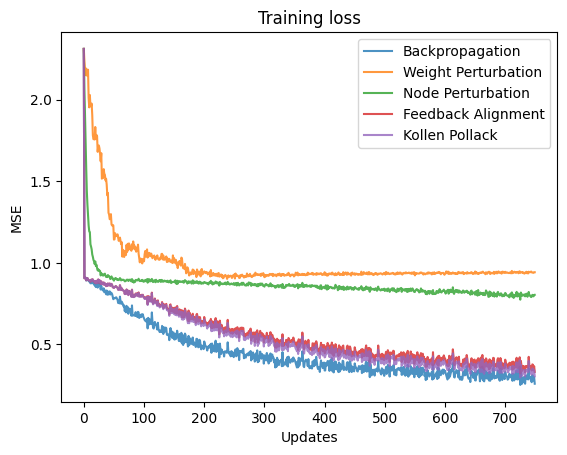

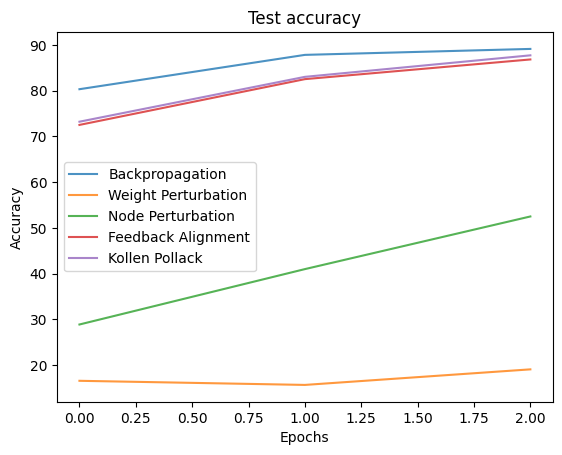

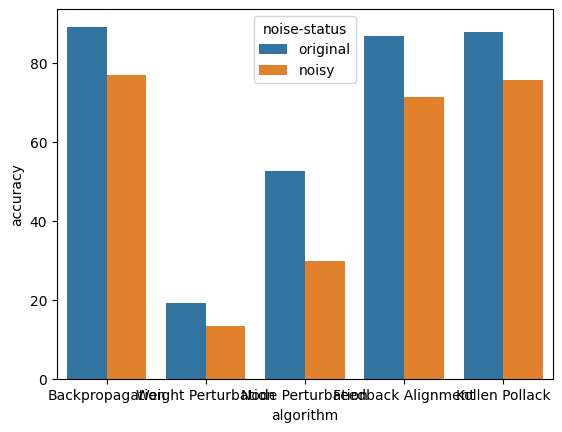

## Results we obtained with 50k training images after resizing to (18,18), 1k test, and 3 epochs

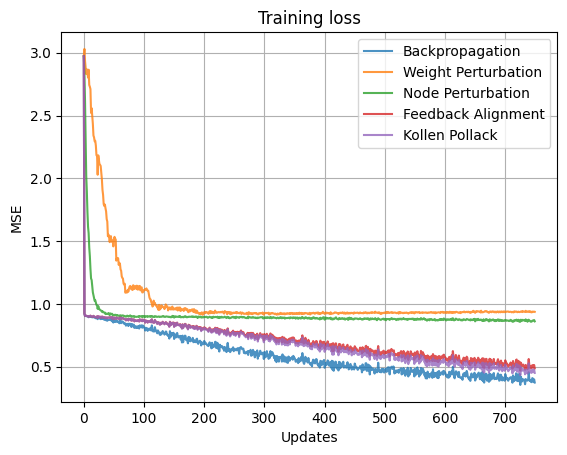

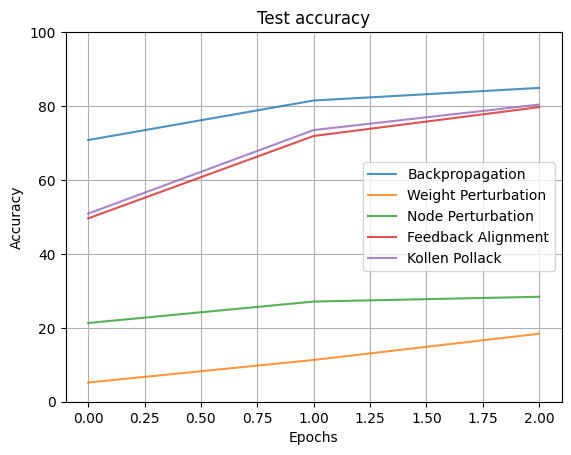

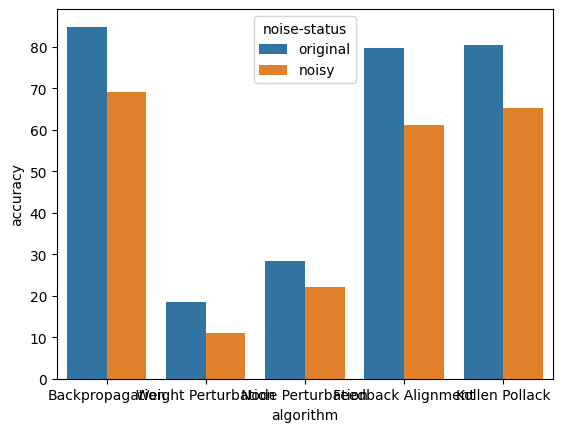

## Example input/output

In [ ]:
# print(train_images.shape)
# example_input = train_images[:, 0:10]
# _, example_output = net.inference(None, example_input)
# print(example_input.shape)
# print(example_output.shape)
# print(example_output)

In [ ]:
# Free memory for variables we no longer use
losses = None
accuracy = None
noisy_accuracy = None
networks = None

## Summation task

In [29]:

excluded_pairs = np.array([(i,j) for i,j in zip(range(3,10), range(3,10))])
print(excluded_pairs)

[[3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [9 9]]


In [30]:
#@title Create dataset for the summation task
# excluded_pairs = [(4, 5), (0, 2), (9, 9), (3, 3)]
excluded_pairs = np.array([(i,j) for i,j in zip(range(3,10), range(3,10))])
train_image_pairs, train_label_pairs = imageLabel_pairs(train_images, train_labels,
                                                        excluded_pairs
                                                        )
test_image_pairs, test_label_pairs = imageLabel_pairs(test_images, test_labels, excluded_pairs[:-2])


In [36]:
# Free up memory used by the original dataset
train_images = None
train_labels = None
test_images = None
test_labels = None

In [31]:
#@title Train and measure performance of the different learning rules on the summation task
perf_data = train_and_test_performance(train_image_pairs, train_label_pairs, test_image_pairs, test_label_pairs, do_time=True)

Backpropagation
Training starting...
...completed  1  epochs of training. Current loss:  0.6 .
...completed  2  epochs of training. Current loss:  0.55 .
...completed  3  epochs of training. Current loss:  0.52 .
Training complete.
Time elapsed for Backpropagation: 30.42s
Weight Perturbation
Training starting...
...completed  1  epochs of training. Current loss:  0.99 .
...completed  2  epochs of training. Current loss:  0.85 .
...completed  3  epochs of training. Current loss:  0.86 .
Training complete.
Time elapsed for Weight Perturbation: 47.87s
Node Perturbation
Training starting...
...completed  1  epochs of training. Current loss:  0.76 .
...completed  2  epochs of training. Current loss:  0.74 .
...completed  3  epochs of training. Current loss:  0.73 .
Training complete.
Time elapsed for Node Perturbation: 431.20s
Feedback Alignment
Training starting...
...completed  1  epochs of training. Current loss:  0.66 .
...completed  2  epochs of training. Current loss:  0.6 .
...comple

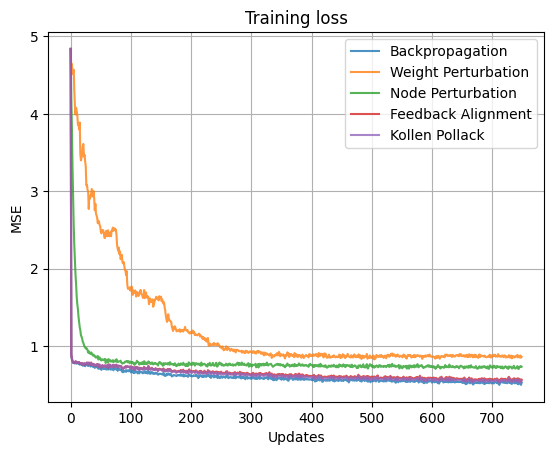

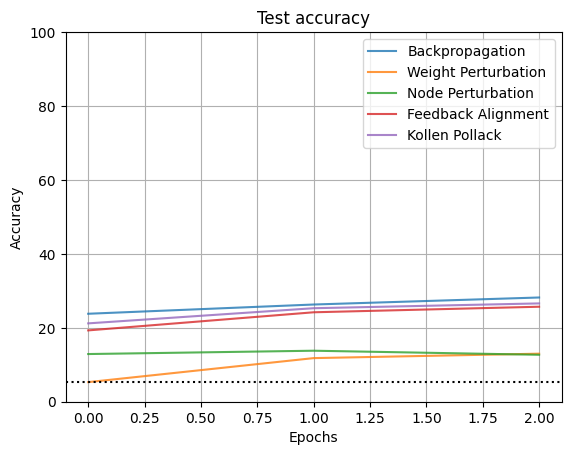

In [32]:
plot_performance(lrules, perf_data["losses"], perf_data["accuracy"],
                 chance_accuracy=1/19*100)

## Results we obtained with 10k training images after resizing to (18,18), 1k test, and 3 epochs - excluded [(4, 5), (0, 2), (9, 9), (3, 3)] pairs


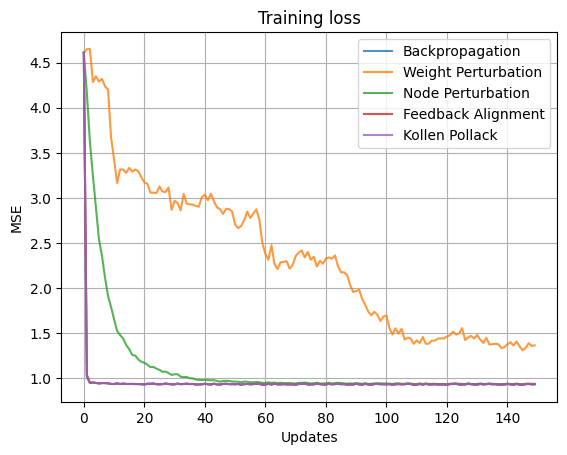

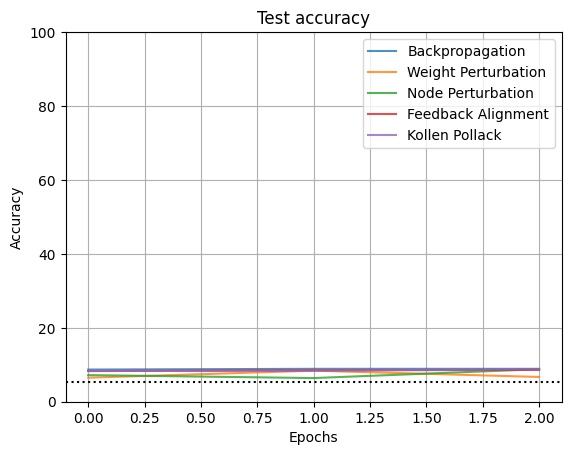

## Results we obtained with 50k training images with original size (28,28), 1k test, and 3 epochs - without exclusion


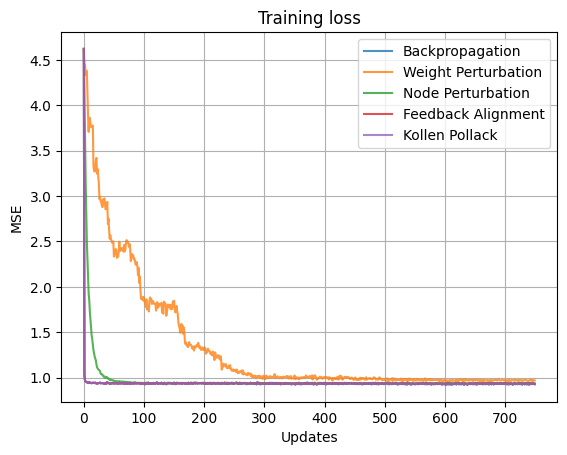

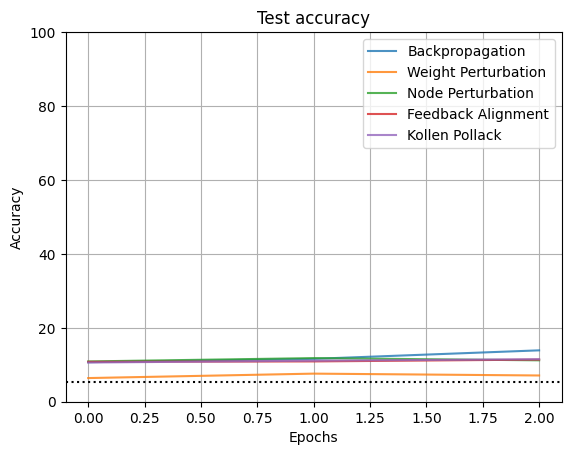

## Results we obtained with 50k training images after resizing to (18,18), 1k test, and 3 epochs - excluded [[3 3]  [4 4]  [5 5]  [6 6]  [7 7]  [8 8] [9 9]] pairs for training and testing


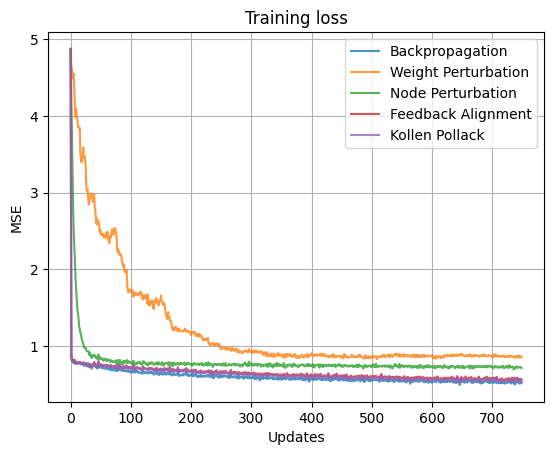

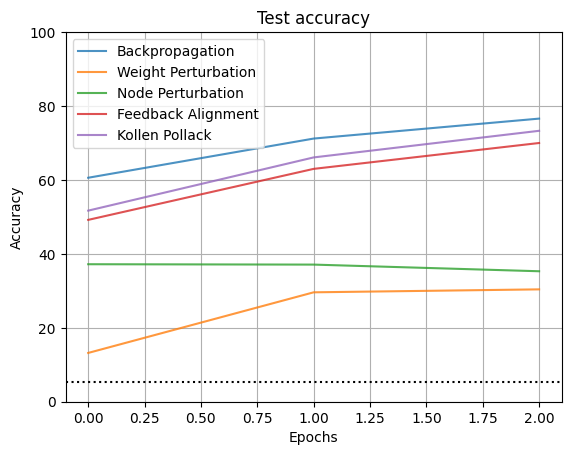

## Results we obtained with 50k training images after resizing to (18,18), 1k test, and 3 epochs - excluded [[3 3]  [4 4]  [5 5]  [6 6]  [7 7]  [8 8] [9 9]] pairs for training,  [[3 3]  [4 4]  [5 5]  [6 6]  [7 7]] pairs for testing.


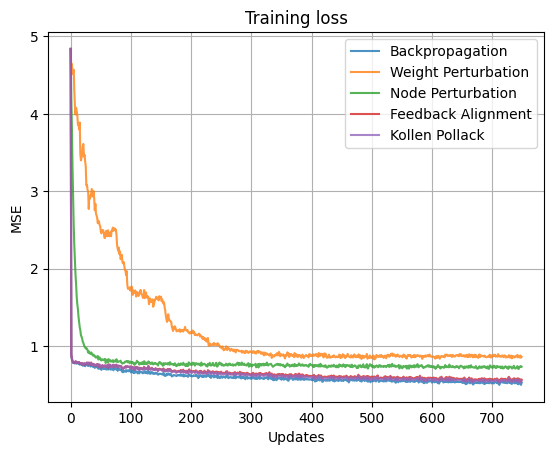

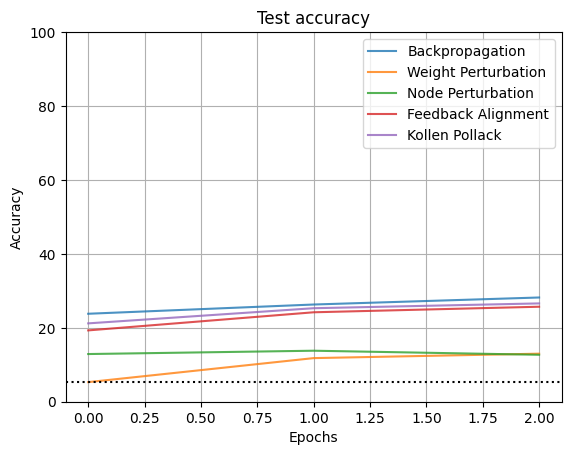